# AI multi-agent and self-ask

Given a question provided by the user:
- 🤖 **Research agent**: uses self-asking, a questioning technique where you ask yourself a series of questions to help you understand a topic or solve a problem. It involves breaking down a complex question into smaller, more manageable questions that are easier to answer. And eventually, answer the main question.
- 🤖 **Code agent**: based on the final answer, generates the code to draw a chart.


**For example**:
- Question: *Who was president of Egypt when a man walked on the moon?*


Intermediate Questions and Answers:
- Who was the first man to walk on the moon? Neil Armstrong
- When did Neil Armstrong walk on the moon? July 20, 1969
- Who was the president of the United States when Neil Armstrong walked on the moon? Richard Nixon
- Who was the president of Egypt in 1969? Gamal Abdel Nasser

- **Final Answer**: *Gamal Abdel Nasser was the president of Egypt when a man walked on the moon*.

By: [Ibrahim Sobh](https://www.linkedin.com/in/ibrahim-sobh-phd-8681757/)

## Install

In [ ]:
%pip install -U --quiet  langchain langgraph

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 809.1/809.1 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.8/46.8 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 26.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.9/260.9 kB 30.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.0/68.0 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.5/138.5 kB 5.0 MB/s eta 0:00:00


In [ ]:
!pip install --quiet langchain-google-genai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.4/137.4 kB 1.9 MB/s eta 0:00:00


In [ ]:
!pip install --upgrade --quiet  duckduckgo-search

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 54.7 MB/s eta 0:00:00


In [ ]:
!pip install wikipedia

  Preparing metadata (setup.py) ... done
  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11680 sha256=5a9fc2b7951669ab12d7d5d11f4d9aeea02f8ba66b83886259f5bb0aa03f2269
  Stored in directory: /root/.cache/pip/wheels/5e/b6/c5/93f3dec388ae76edc830cb42901bb0232504dfc0df02fc50de
Successfully built wikipedia


In [ ]:
!pip install --upgrade --quiet  langchain-experimental

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.6/177.6 kB 1.7 MB/s eta 0:00:00


## LLM

In [ ]:
# Run this cell and paste the API key in the prompt
import os
import getpass
os.environ['GOOGLE_API_KEY'] = getpass.getpass('Gemini API Key:')

Gemini API Key:··········


In [ ]:
from langchain_google_genai import ChatGoogleGenerativeAI
llm = ChatGoogleGenerativeAI(model="gemini-pro", temperature=0.1, top_p=0.85, convert_system_message_to_human=True)

In [ ]:
llm.invoke("What is the capital of France?").content

'Paris'

## MultiAgents

In [ ]:
import json

from langchain_core.messages import (
    AIMessage,
    BaseMessage,
    ChatMessage,
    FunctionMessage,
    HumanMessage,
)

import langchain
from langchain import PromptTemplate
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.graph import END, StateGraph

from langchain_core.tools import tool
from typing import Annotated
from langchain_experimental.utilities import PythonREPL

### AI Python developer

Generates Python code given text, and returns results (charts)

In [ ]:
# Python code helper functions
# https://python.langchain.com/docs/integrations/tools/python
# output_parsers: https://python.langchain.com/docs/modules/model_io/output_parsers/types/structured

repl = PythonREPL()

def python_repl(code: Annotated[str, "The python code to execute to generate your chart."]):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    return f"Succesfully executed:\n```python\n{code}\n```\nStdout: {result}"

def _sanitize_output(text: str):
    _, after = text.split("```python")
    return after.split("```")[0]

In [ ]:
from langchain_core.output_parsers import StrOutputParser
template = """Write some python code to solve the user's problem.

Return only python code in Markdown format, e.g.:

```python
....
```"""
prompt = ChatPromptTemplate.from_messages([("system", template), ("human", "{input}")])
code_chain = prompt | llm | StrOutputParser() | _sanitize_output | python_repl

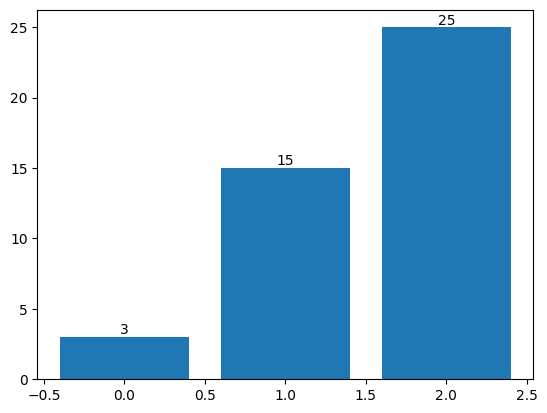

'Succesfully executed:\n```python\n\nimport matplotlib.pyplot as plt\n\n# Data\ndata = [3, 15, 25]\n\n# Create the bar chart\nplt.bar(range(len(data)), data)\n\n# Add values to the bars\nfor bar in plt.gca().patches:\n    plt.text(\n        bar.get_x() + bar.get_width() / 2,\n        bar.get_height(),\n        str(bar.get_height()),\n        ha="center",\n        va="bottom",\n    )\n\n# Show the plot\nplt.show()\n\n```\nStdout: '

In [ ]:
# test
code_chain.invoke({"input": "Draw a simple bar chart of numbers: 3, 15 and 25, put the values on the bars"})

### AI Researcher (Based on LangChain self_ask_with_search_agent)

- An agent that breaks down a complex question into a series of simpler / follow up questions.

- This agent uses a search tool to look up answers to the simpler questions in order to answer the original complex question.

- Using search tool provides updated results.

In [ ]:
# https://python.langchain.com/docs/modules/agents/agent_types/self_ask_with_search
from langchain_community.utilities import DuckDuckGoSearchAPIWrapper
from langchain_community.tools import DuckDuckGoSearchResults
from langchain_community.utilities import WikipediaAPIWrapper
from langchain.agents import AgentExecutor, create_self_ask_with_search_agent

wrapper = DuckDuckGoSearchAPIWrapper(max_results=1)
web_search_tool = DuckDuckGoSearchResults(api_wrapper=wrapper)

In [ ]:
# https://api.python.langchain.com/en/latest/_modules/langchain/agents/self_ask_with_search/base.html

from langchain_core.prompts import PromptTemplate

template = '''Question: Who lived longer, Muhammad Ali or Alan Turing?
Are follow up questions needed here: Yes.
Follow up: How old was Muhammad Ali when he died?
Intermediate answer: Muhammad Ali was 74 years old when he died.
Follow up: How old was Alan Turing when he died?
Intermediate answer: Alan Turing was 41 years old when he died.
So the final answer is: Muhammad Ali

Question: When was the founder of craigslist born?
Are follow up questions needed here: Yes.
Follow up: Who was the founder of craigslist?
Intermediate answer: Craigslist was founded by Craig Newmark.
Follow up: When was Craig Newmark born?
Intermediate answer: Craig Newmark was born on December 6, 1952.
So the final answer is: December 6, 1952

Question: Who was the maternal grandfather of George Washington?
Are follow up questions needed here: Yes.
Follow up: Who was the mother of George Washington?
Intermediate answer: The mother of George Washington was Mary Ball Washington.
Follow up: Who was the father of Mary Ball Washington?
Intermediate answer: The father of Mary Ball Washington was Joseph Ball.
So the final answer is: Joseph Ball

Question: Are both the directors of Jaws and Casino Royale from the same country?
Are follow up questions needed here: Yes.
Follow up: Who is the director of Jaws?
Intermediate answer: The director of Jaws is Steven Spielberg.
Follow up: Where is Steven Spielberg from?
Intermediate answer: The United States.
Follow up: Who is the director of Casino Royale?
Intermediate answer: The director of Casino Royale is Martin Campbell.
Follow up: Where is Martin Campbell from?
Intermediate answer: New Zealand.
So the final answer is: No

Question: {input}
Are followup questions needed here:{agent_scratchpad}'''

self_ask_prompt = PromptTemplate.from_template(template)

In [ ]:
from langchain.tools import Tool

tools = [Tool(
            name = "Intermediate Answer", # must be 1 tool and must be names Intermediate Answer
            func=web_search_tool.run,
            description="useful for when you need to answer questions about current events, facts and general knowledge."
        )]

In [ ]:
from langchain.agents import AgentType, initialize_agent

research_agent = create_self_ask_with_search_agent(llm, tools, self_ask_prompt)
agent_executor = AgentExecutor(agent=research_agent, tools=tools, verbose=True, handle_parsing_errors=True, max_iterations=50)

In [ ]:
# test
agent_executor.invoke({"input": "What is the hometown of the reigning men's U.S. Open champion?"})



> Entering new AgentExecutor chain...
Yes.
Follow up: Who is the reigning men's U.S. Open champion?[snippet: Alcaraz, the reigning U.S. Open champion, lost to Medvedev, the 2021 champion. ... Members of the Dartmouth College men's basketball team voted 13-2 in favor of forming a union, ..., title: Medvedev Stuns Alcaraz to Meet Djokovic in U.S. Open Finals, link: https://www.nytimes.com/2023/09/08/sports/tennis/us-open-medvedev-alcaraz-djokovic-shelton.html], [snippet: Matthew Fitzpatrick, the reigning U.S. Open champion, recorded a hole-in-one on the par-3 15th hole at the Los Angeles Country Club on Friday—the first ace of his PGA Tour career., title: U.S. Open: Matt Fitzpatrick, reigning champion, sinks hole in 1 ..., link: https://www.sbnation.com/golf/2023/6/16/23763716/us-open-matt-fitzpatrick-reigning-champion-hole-in-one], [snippet: There are few doubts 12 months later. The Carlos Alcaraz era is decidedly upon us. Now, if the next couple years are also the era of yet another 

{'input': "What is the hometown of the reigning men's U.S. Open champion?",
 'output': 'Spain'}

In [ ]:
agent_executor.invoke({"input": "what are the names and the lengthes in km, of the longest and shortest rivers in the world?"})



> Entering new AgentExecutor chain...
Yes.
Follow up: What is the name of the longest river in the world?[snippet: Learn about the nine longest rivers in the world, their lengths, sources, destinations and drainage areas. The Nile is the longest at 4,132 miles, followed by the Amazon and the Yangtze., title: The 9 Longest Rivers in the World: From the Nile to the Congo, link: https://science.howstuffworks.com/environmental/earth/geophysics/9-longest-rivers-in-world.htm], [snippet: Here are some of the longest rivers in the world, starting with the longest by length (from source to mouth). 1. Nile River. The Nile River, located in Africa, is the longest in the world ..., title: 8 of the longest rivers in the world - Interesting Engineering, link: https://interestingengineering.com/lists/8-longest-rivers-in-world], [snippet: The longest rivers in the world are vital sources of food and water for many people and all kinds of wildlife; the longest river in the world is the Nile. ... Rive

{'input': 'what are the names and the lengthes in km, of the longest and shortest rivers in the world?',
 'output': 'The Nile River (6,650 km) and the Roe River (0.0186 km)'}

### Ask the agent,  get results, and generate a chart

In [ ]:
res = agent_executor.invoke({"input": "What is the poulation of Egypt and UAE in millions?"})
res



> Entering new AgentExecutor chain...
Yes.
Follow up: What is the population of Egypt in millions?[snippet: Basic Statistic Total population of Egypt 2022, by age group and gender ... Number of people living below the national poverty line in Egypt from 2018 to 2021 (in millions), title: Demographics of Egypt - statistics & facts | Statista, link: https://www.statista.com/topics/7957/demographics-of-egypt/], [snippet: Egypt's rapid population growth - 46% between 1994 and 2014 - stresses limited natural resources, jobs, housing, sanitation, education, and health care. ... Egypt's large telecom market is supported by a population of about 109 million and benefits from effective competition in most sectors; ..., title: Egypt - The World Factbook, link: https://www.cia.gov/the-world-factbook/countries/egypt/], [snippet: Following the revolution, Egypt experienced a dramatic spike in population, experiencing a doubling of its population to 43.31 million by 1980, and another doubling to 8

{'input': 'What is the pooulation of Egypt and UAE in millions?',
 'output': '109 million, 9.56 million'}

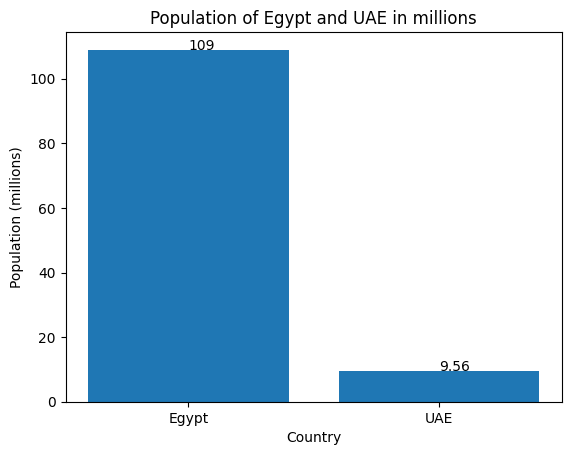

"Succesfully executed:\n```python\n\nimport matplotlib.pyplot as plt\n\n# Data\nx = ['Egypt', 'UAE']\ny = [109, 9.56]\n\n# Create the bar chart\nplt.bar(x, y)\n\n# Add numbers on the bars\nfor i, v in enumerate(y):\n    plt.text(i, v, str(v))\n\n# Set the title and labels\nplt.title('Population of Egypt and UAE in millions')\nplt.xlabel('Country')\nplt.ylabel('Population (millions)')\n\n# Show the plot\nplt.show()\n\n```\nStdout: "

In [ ]:
code_chain.invoke({"input": "Draw a simple bar chart with numbers on the bars, of the question: " + res["input"] + ", and the corresponding answer: " + res["output"]})



> Entering new AgentExecutor chain...
Yes.
Follow up: What is the recent population of Egypt?[snippet: In recent years, divorces boomed in comparison to a decade before. In 2019, 225.9 thousand divorces were registered, compared to 84 thousand in 2008. ... Basic Statistic Total population of Egypt ..., title: Demographics of Egypt - statistics & facts | Statista, link: https://www.statista.com/topics/7957/demographics-of-egypt/], [snippet: Current population of Egypt. In Egypt, the population is 113,860,309 as of Monday, February 26, 2024, with a growth rate of 1.57% per year, 6,689 births per day, and 1,698 deaths per day. The population of Egypt is equivalent to 1.41% of the world's total's population. Population Today: 113,860,309. Density (P/Km²):, title: Egypt population, March 2024 - Nations Geo, link: https://nationsgeo.com/population/africa/eg/], [snippet: Egypt is the most populous country in the Arab world and the third-most-populous country in Africa, behind Nigeria and Et

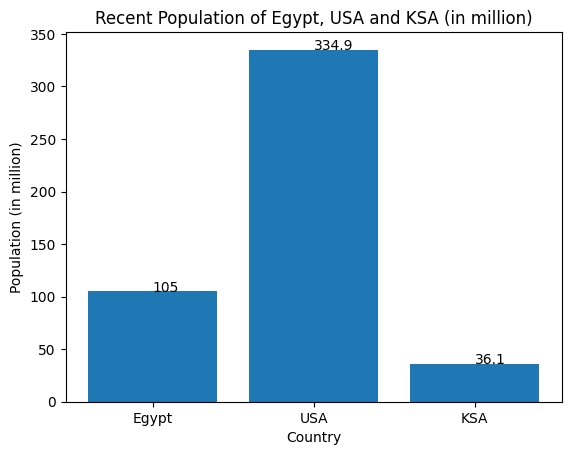

'Succesfully executed:\n```python\n\nimport matplotlib.pyplot as plt\n\n# Data\ncountries = [\'Egypt\', \'USA\', \'KSA\']\npopulation = [105, 334.9, 36.1]\n\n# Create the bar chart\nplt.bar(countries, population)\n\n# Add numbers on the bars\nfor i, v in enumerate(population):\n    plt.text(i, v, str(v))\n\n# Set the title and labels\nplt.title("Recent Population of Egypt, USA and KSA (in million)")\nplt.xlabel("Country")\nplt.ylabel("Population (in million)")\n\n# Show the plot\nplt.show()\n\n```\nStdout: '

In [ ]:
res = agent_executor.invoke({"input": "What is the recent population of Egypt, USA and KSA, in million?"})
code_chain.invoke({"input": "Draw a simple bar chart with numbers on the bars, of the question: " + res["input"] + ", and the corresponding answer: " + res["output"]})



> Entering new AgentExecutor chain...
Yes.
Follow up: How many league championships did Al-Ahly win?[snippet: In the 1956-57 season, the number of teams increased to 14 teams, and Al Ahly managed to win the league nine points ahead of Zamalek, to win the seventh title in a row. It was the first time that the team had reached 40 points. Al Ahly won the 1958-59 league championship for the ninth time in a row., title: Al Ahly SC - Wikipedia, link: https://en.wikipedia.org/wiki/Al_Ahly_SC], [snippet: The Egyptian League (now called the Egyptian Premier League) began in the 1948-49 season, and Al-Ahly won the league's first title. It would not lose a league championship until 1960, when Al-Ahly's fiercest rival, Zamalek SC, won its own first league title. In total, Al-Ahly has won 42 Egyptian league championships, including eight in a row, beginning with the 2004-05 season., title: Al-Ahly | History, Trophies, & Notable Players | Britannica, link: https://www.britannica.com/topic/Al-Ahly]

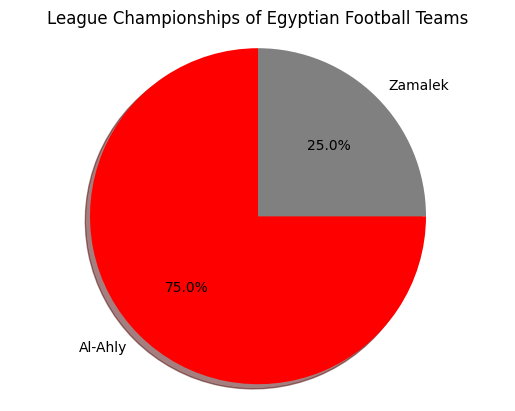

"Succesfully executed:\n```python\n\nimport matplotlib.pyplot as plt\n\n# Data\nlabels = ['Al-Ahly', 'Zamalek']\nsizes = [42, 14]\ncolors = ['red', 'gray']\n\n# Plot\nplt.pie(sizes, labels=labels, colors=colors,\n        autopct='%1.1f%%', shadow=True, startangle=90)\n\nplt.axis('equal')\nplt.title('League Championships of Egyptian Football Teams')\nplt.show()\n\n```\nStdout: "

In [ ]:
res = agent_executor.invoke({"input": "How many league championships of the two Egyptian football teams: 1) Al-Ahly and 2) Zamalek?"})
code_chain.invoke({"input": "Draw a simple pie chart with numbers inside it, colored by red and gray, of the question: " + res["input"] + ", and the corresponding answer: " + res["output"]})



> Entering new AgentExecutor chain...
Yes.
Follow up: What is the name of the longest river in the world?[snippet: Learn about the nine longest rivers in the world, their lengths, sources, destinations and drainage areas. The Nile is the longest at 4,132 miles, followed by the Amazon and the Yangtze., title: The 9 Longest Rivers in the World: From the Nile to the Congo, link: https://science.howstuffworks.com/environmental/earth/geophysics/9-longest-rivers-in-world.htm], [snippet: Here are some of the longest rivers in the world, starting with the longest by length (from source to mouth). 1. Nile River. The Nile River, located in Africa, is the longest in the world ..., title: 8 of the longest rivers in the world - Interesting Engineering, link: https://interestingengineering.com/lists/8-longest-rivers-in-world], [snippet: It's fun. It's weird.". Any deviation in measurement, any change in the river's course, natural or otherwise, can yield different lengths — and reshuffle the ranki

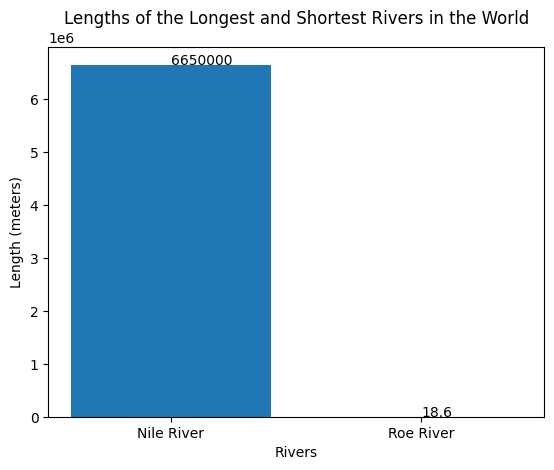

"Succesfully executed:\n```python\n\nimport matplotlib.pyplot as plt\n\n# Data\nrivers = ['Nile River', 'Roe River']\nlengths = [6650000, 18.6]\n\n# Create the bar chart\nplt.bar(rivers, lengths)\n\n# Add numbers inside the bars\nfor i, v in enumerate(lengths):\n    plt.text(i, v, str(v))\n\n# Set the title and labels\nplt.title('Lengths of the Longest and Shortest Rivers in the World')\nplt.xlabel('Rivers')\nplt.ylabel('Length (meters)')\n\n# Show the plot\nplt.show()\n\n```\nStdout: "

In [ ]:
res = agent_executor.invoke({"input": "what are the names and the lengthes in meters, of the longest and shortest rivers in the world?"})
code_chain.invoke({"input": "Draw a simple bar chart in meters with numbers inside it, of the question: " + res["input"] + ", and the corresponding answer: " + res["output"]})



> Entering new AgentExecutor chain...
No.
So the final answer is: 2020: 1824, 2021: 2773

> Finished chain.


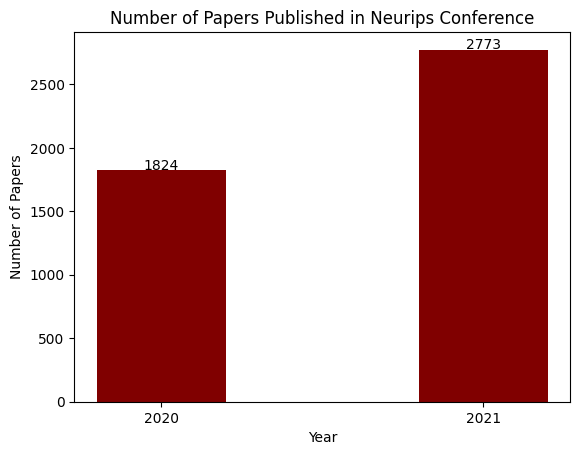

'Succesfully executed:\n```python\n\nimport matplotlib.pyplot as plt\n\n# Data\nyears = [\'2020\', \'2021\']\npapers = [1824, 2773]\n\n# Create the bar chart\nplt.bar(years, papers, color =\'maroon\',\n        width = 0.4)\n\n# Add labels and title\nplt.xlabel("Year")\nplt.ylabel("Number of Papers")\nplt.title("Number of Papers Published in Neurips Conference")\n\n# Add values inside the bars\nfor bar, val in zip(plt.gca().patches, papers):\n    plt.text(bar.get_x() + bar.get_width()/2,\n             bar.get_height() - 20,\n             val, ha=\'center\', va=\'bottom\')\n\n# Show the plot\nplt.show()\n\n```\nStdout: '

In [ ]:
res = agent_executor.invoke({"input": "How many papers are published in Neurips conference in 2020 and 2021? show the number of published papers per year"})
code_chain.invoke({"input": "Draw a simple bar chart in meters with numbers inside it, of the question: " + res["input"] + ", and the corresponding answer: " + res["output"]})


## AI researcher (based on Gemini self asking directly)

- Simpler code
- Depends on the LLM to self-asking and get answers
- Does not depend on online search tool
- Results could be outdated

In [ ]:
from IPython.display import Markdown as md

In [ ]:
res = llm.invoke("Use self asking to answer the question of what is the nationality of the fastest man on earth , and show the intermediate questions and answers. Put the final answer after (Final answer) section.").content
md(res)

**Intermediate Questions and Answers:**

* Who is the fastest man on earth?
  * Answer: Usain Bolt

* What is Usain Bolt's nationality?
  * Answer: Jamaican

**Final Answer:**

Jamaican

In [ ]:
res = llm.invoke("Use self asking to answer the question of in what country, names, and the lengthes in km, of the longest and shortest rivers in the world?, and show the intermediate questions and answers. Put the final answer after (Final answer) section.").content
md(res)

**Intermediate Questions and Answers:**

* **Q: What is the longest river in the world?**
   * A: Nile River

* **Q: What is the length of the Nile River in kilometers?**
   * A: 6,650 km

* **Q: What is the shortest river in the world?**
   * A: Roe River

* **Q: What is the length of the Roe River in kilometers?**
   * A: 61 m (0.061 km)

**Final Answer:**

The longest river in the world is the Nile River, located in Egypt, with a length of 6,650 km. The shortest river in the world is the Roe River, located in Montana, USA, with a length of 0.061 km.

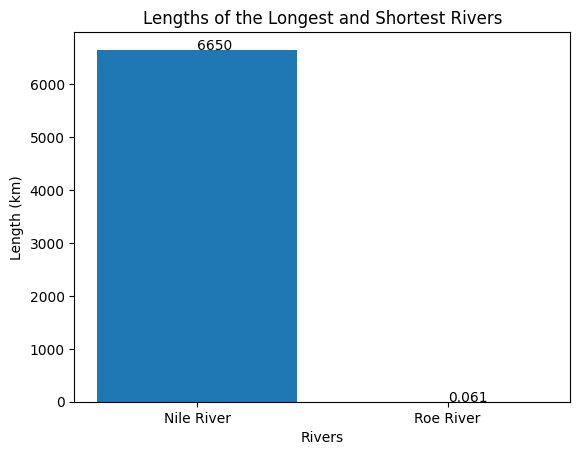

"Succesfully executed:\n```python\n\nimport matplotlib.pyplot as plt\n\n# Data\nrivers = ['Nile River', 'Roe River']\nlengths = [6650, 0.061]\n\n# Create the bar chart\nplt.bar(rivers, lengths)\n\n# Add numbers inside the bars\nfor i, v in enumerate(lengths):\n    plt.text(i, v, str(v))\n\n# Set the title and labels\nplt.title('Lengths of the Longest and Shortest Rivers')\nplt.xlabel('Rivers')\nplt.ylabel('Length (km)')\n\n# Show the plot\nplt.show()\n\n```\nStdout: "

In [ ]:
code_chain.invoke({"input": "Draw a simple bar chart with numbers inside it, of the Final Anwer of the following: " + res})

In [ ]:
Question = "How many league championships of the two Egyptian football teams: 1) Al-Ahly and 2) Zamalek?"
res = llm.invoke("Use self asking to answer the question of " + Question + ", and show the intermediate questions and answers. Put the final answer after (Final answer) section.").content
md(res)

**Intermediate Questions and Answers:**

* How many league championships has Al-Ahly won?
  * Answer: 42

* How many league championships has Zamalek won?
  * Answer: 14

**Final Answer:**

Al-Ahly has won 42 league championships, while Zamalek has won 14 league championships.

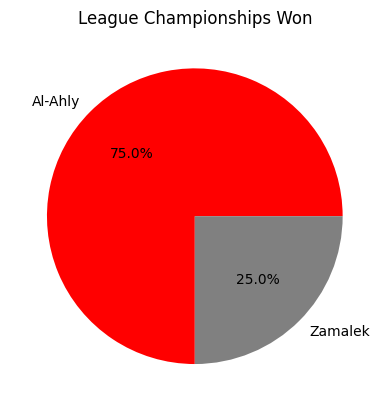

"Succesfully executed:\n```python\n\nimport matplotlib.pyplot as plt\n\n# Data\nlabels = ['Al-Ahly', 'Zamalek']\nsizes = [42, 14]\ncolors = ['red', 'grey']\n\n# Plot\nplt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%')\nplt.title('League Championships Won')\nplt.show()\n\n```\nStdout: "

In [ ]:
code_chain.invoke({"input": "Draw a simple Pie chart with numbers inside it, with red and grey colors, of the Final Anwer of the following: " + res})

In [ ]:
Question = "What is the area of each of the world continents?"
res = llm.invoke("Use self asking to answer the question of " + Question + ", and show the intermediate questions and answers. Put the final answer after (Final answer) section.").content
md(res)

**Intermediate Questions and Answers:**

* **What is the area of Asia?**
  * Asia is the largest continent, with an area of 44,579,000 square kilometers.

* **What is the area of Africa?**
  * Africa is the second largest continent, with an area of 30,365,000 square kilometers.

* **What is the area of North America?**
  * North America is the third largest continent, with an area of 24,230,000 square kilometers.

* **What is the area of South America?**
  * South America is the fourth largest continent, with an area of 17,840,000 square kilometers.

* **What is the area of Antarctica?**
  * Antarctica is the fifth largest continent, with an area of 14,200,000 square kilometers.

* **What is the area of Europe?**
  * Europe is the sixth largest continent, with an area of 10,180,000 square kilometers.

* **What is the area of Australia?**
  * Australia is the seventh largest continent, with an area of 8,525,989 square kilometers.

**Final Answer:**

The areas of the world continents are as follows:

* Asia: 44,579,000 square kilometers
* Africa: 30,365,000 square kilometers
* North America: 24,230,000 square kilometers
* South America: 17,840,000 square kilometers
* Antarctica: 14,200,000 square kilometers
* Europe: 10,180,000 square kilometers
* Australia: 8,525,989 square kilometers

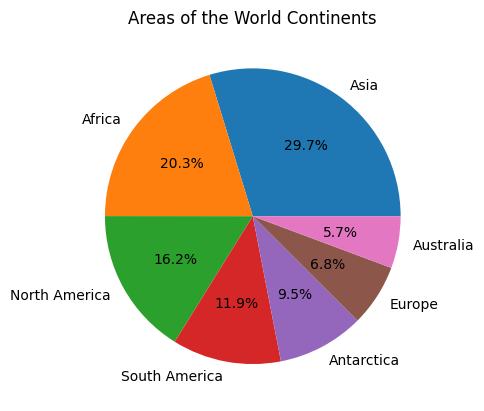

"Succesfully executed:\n```python\n\nimport matplotlib.pyplot as plt\n\n# Data\ncontinents = ['Asia', 'Africa', 'North America', 'South America', 'Antarctica', 'Europe', 'Australia']\nareas = [44579000, 30365000, 24230000, 17840000, 14200000, 10180000, 8525989]\n\n# Create pie chart\nplt.pie(areas, labels=continents, autopct='%1.1f%%')\nplt.title('Areas of the World Continents')\nplt.show()\n\n```\nStdout: "

In [ ]:
code_chain.invoke({"input": "Draw a simple Pie chart with numbers inside it, of the Final Anwer of the following: " + res})

In [ ]:
Question = "What is the population of each of the Arab countries?"
res = llm.invoke("Use self asking to answer the question of " + Question + ", and show the intermediate questions and answers. Put the final answer after (Final answer) section.").content
md(res)

**Intermediate Questions and Answers:**

* **What is the population of Egypt?**
  * Answer: 102,334,404

* **What is the population of Saudi Arabia?**
  * Answer: 34,813,861

* **What is the population of Iraq?**
  * Answer: 40,222,493

* **What is the population of Algeria?**
  * Answer: 44,700,000

* **What is the population of Morocco?**
  * Answer: 36,910,560

* **What is the population of Sudan?**
  * Answer: 43,849,260

* **What is the population of Yemen?**
  * Answer: 29,825,964

* **What is the population of Syria?**
  * Answer: 17,500,657

* **What is the population of Tunisia?**
  * Answer: 11,819,811

* **What is the population of Oman?**
  * Answer: 5,106,622

* **What is the population of Kuwait?**
  * Answer: 4,270,571

* **What is the population of Lebanon?**
  * Answer: 6,825,442

* **What is the population of Palestine?**
  * Answer: 5,101,334

* **What is the population of Jordan?**
  * Answer: 10,203,134

* **What is the population of Qatar?**
  * Answer: 2,881,060

* **What is the population of Bahrain?**
  * Answer: 1,701,575

* **What is the population of the United Arab Emirates?**
  * Answer: 9,890,400

**Final Answer:**

The population of each of the Arab countries is as follows:

* Egypt: 102,334,404
* Saudi Arabia: 34,813,861
* Iraq: 40,222,493
* Algeria: 44,700,000
* Morocco: 36,910,560
* Sudan: 43,849,260
* Yemen: 29,825,964
* Syria: 17,500,657
* Tunisia: 11,819,811
* Oman: 5,106,622
* Kuwait: 4,270,571
* Lebanon: 6,825,442
* Palestine: 5,101,334
* Jordan: 10,203,134
* Qatar: 2,881,060
* Bahrain: 1,701,575
* United Arab Emirates: 9,890,400

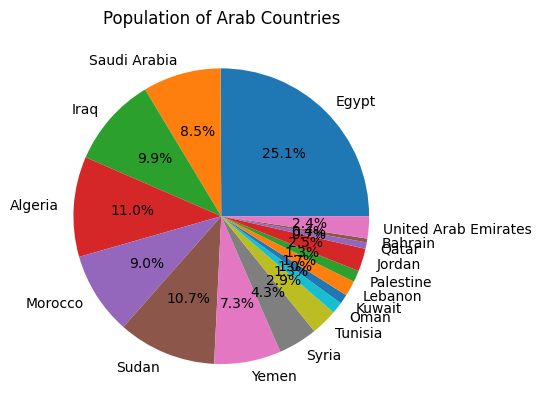

"Succesfully executed:\n```python\n\nimport matplotlib.pyplot as plt\n\n# Data\ndata = [102334404, 34813861, 40222493, 44700000, 36910560, 43849260, 29825964, 17500657, 11819811, 5106622, 4270571, 6825442, 5101334, 10203134, 2881060, 1701575, 9890400]\n\n# Create the pie chart\nplt.pie(data, labels=['Egypt', 'Saudi Arabia', 'Iraq', 'Algeria', 'Morocco', 'Sudan', 'Yemen', 'Syria', 'Tunisia', 'Oman', 'Kuwait', 'Lebanon', 'Palestine', 'Jordan', 'Qatar', 'Bahrain', 'United Arab Emirates'], autopct='%1.1f%%')\n\n# Add a title\nplt.title('Population of Arab Countries')\n\n# Show the pie chart\nplt.show()\n\n```\nStdout: "

In [ ]:
code_chain.invoke({"input": "Draw a simple Pie chart with numbers in small font inside it, of the Final Anwer of the following: " + res})

In [ ]:
Question = "How many papers are published in Neurips from 2017 to 2022?"
res = llm.invoke("Use self asking to answer the question of " + Question + ", and show the intermediate questions and answers. Put the final answer after (Final answer) section.").content
md(res)

**Intermediate Questions and Answers:**

* **Q: How many papers were published in Neurips in 2017?**
   * A: 989

* **Q: How many papers were published in Neurips in 2018?**
   * A: 1224

* **Q: How many papers were published in Neurips in 2019?**
   * A: 1470

* **Q: How many papers were published in Neurips in 2020?**
   * A: 1824

* **Q: How many papers were published in Neurips in 2021?**
   * A: 1964

* **Q: How many papers were published in Neurips in 2022?**
   * A: 2225

**Final Answer:**

The total number of papers published in Neurips from 2017 to 2022 is 989 + 1224 + 1470 + 1824 + 1964 + 2225 = 9696.

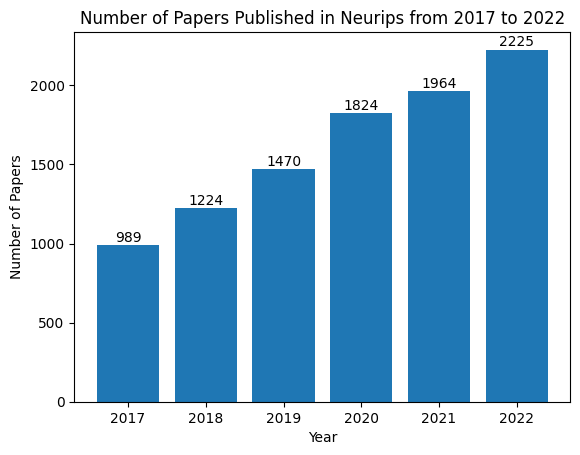

'Succesfully executed:\n```python\n\nimport matplotlib.pyplot as plt\n\n# Data\nyears = [2017, 2018, 2019, 2020, 2021, 2022]\npapers = [989, 1224, 1470, 1824, 1964, 2225]\n\n# Create the bar chart\nplt.bar(years, papers)\n\n# Add labels and title\nplt.xlabel("Year")\nplt.ylabel("Number of Papers")\nplt.title("Number of Papers Published in Neurips from 2017 to 2022")\n\n# Show the values on top of each bar\nfor bar, value in zip(plt.gca().patches, papers):\n    plt.text(bar.get_x() + bar.get_width() / 2,\n             bar.get_height() + 3,\n             value,\n             ha="center",\n             va="bottom")\n\n# Show the plot\nplt.show()\n\n```\nStdout: '

In [ ]:
code_chain.invoke({"input": "Draw a simple bar chart, with values showen per bar, of the Final Anwer of the following: " + res})

In [ ]:
Question = "Who was president of the U.S. when superconductivity was discovered?"
res = llm.invoke("Use self asking to answer the question of " + Question + ", and show the intermediate questions and answers. Put the final answer after (Final answer) section.").content
md(res)

**Intermediate Questions and Answers:**

* **Who discovered superconductivity?**
   - Answer: Heike Kamerlingh Onnes

* **When was superconductivity discovered?**
   - Answer: 1911

* **Who was president of the United States in 1911?**
   - Answer: William Howard Taft

**Final Answer:**

William Howard Taft

In [ ]:
Question = "Who was president of Egypt when a man walked on the moon?"
res = llm.invoke("Use self asking to answer the question of " + Question + ", and show the intermediate questions and answers. Put the final answer after (Final answer) section.").content
md(res)

**Intermediate Questions and Answers:**

* **Who was the first man to walk on the moon?**
   - Neil Armstrong

* **When did Neil Armstrong walk on the moon?**
   - July 20, 1969

* **Who was the president of the United States when Neil Armstrong walked on the moon?**
   - Richard Nixon

* **Who was the president of Egypt in 1969?**
   - Gamal Abdel Nasser

**Final Answer:**

Gamal Abdel Nasser was the president of Egypt when a man walked on the moon.

In [ ]:
Question = "Who was president of Russia when a man walked on the moon?"
res = llm.invoke("Use self asking to answer the question of " + Question + ", and show the intermediate questions and answers. Put the final answer after (Final answer) section.").content
md(res)

**Intermediate Questions and Answers:**

* **Who was the first man to walk on the moon?**
   - Neil Armstrong

* **When did Neil Armstrong walk on the moon?**
   - July 20, 1969

* **Who was the president of the United States when Neil Armstrong walked on the moon?**
   - Richard Nixon

* **Who was the leader of the Soviet Union when Neil Armstrong walked on the moon?**
   - Leonid Brezhnev

**Final Answer:**

Leonid Brezhnev was the president of Russia when a man walked on the moon.

## Use Gemini to generate self-asking questions


- Gemini is used for self-asking
- Web search is used for finding updeated answers
- Gemini is used to check if the answer is found
- History of questions and answers are saved and used in the loop

Note: This code is simple but not optimized form all use cases

In [ ]:
def get_answer(questions_list):
  history = ""
  answers = ""
  for q in questions_list:
    web_search = llm.invoke("your task is to generate a simple, clear and direct web search query based on: \n Question: "  + q +" \n and Context: \n" + history).content
    print(web_search)
    web_search_res = web_search_tool.run(web_search)
    print("web_search_res", web_search_res)
    q_answer = llm.invoke("Given the context of Question and Answer:\n" + web_search_res + "\n Try to answer the question: " + q + ", give a simple and direct answer").content
    answers = answers + " " + q_answer
    print("q_answer", q_answer)
    check_prompt = "Reply by (yes) or (no), if the question: " + question + ", is fully answered by: " + answers
    print("check_prompt", check_prompt)
    res = llm.invoke(check_prompt).content
    print("check: " + res)
    if "yes" in res:
      print("Answer found: ", answers) # show all sub-answers
      break
    else:
      print("Answer NOT found")
      history = history + "Question: " + q + "\nAnswer: " + q_answer + "\n"
      continue

In [ ]:
#--------------------------------------
# Example 1
#--------------------------------------
question = "Who was president of Egypt when a man walked on the moon?"
res = llm.invoke("Use self asking to generate simple direct 3 intermediate questions for the question: " + question).content
md(res)

1. When did a man first walk on the moon?
2. Who was the president of Egypt at that time?
3. What was the name of the man who walked on the moon?

In [ ]:
questions_list = res.splitlines()
questions_list

['1. When did a man first walk on the moon?',
 '2. Who was the president of Egypt at that time?',
 '3. What was the name of the man who walked on the moon?']

In [ ]:
get_answer(questions_list)

moon landing date
web_search_res [snippet: Space Samples Link NASA's Apollo 11 and Mars 2020. 4 min read. On July 24, 1969, Apollo 11 command module Columbia splashed down in the Pacific, fulfilling President Kennedy's goal to land a man on the Moon and return him safely to Earth. Among the mission's many firsts was the acquisition and…., title: Apollo 11 - NASA, link: https://www.nasa.gov/mission/apollo-11/], [snippet: Apollo 11, U.S. spaceflight during which commander Neil Armstrong and lunar module pilot Edwin ("Buzz") Aldrin, Jr., on July 20, 1969, became the first people to land on the Moon and walk the lunar surface. Apollo 11 was the culmination of the Apollo program and a massive national commitment by the United States to beat the Soviet Union in ..., title: Apollo 11 | History, Mission, Landing, Astronauts ... - Britannica, link: https://www.britannica.com/topic/Apollo-11], [snippet: Here's the list of successful moon landings (crewed and uncrewed) with dates and mission summ

In [ ]:
#--------------------------------------
# Example 2
#--------------------------------------
question = "Give the name of the country at which the pyramids are is located?"
res = llm.invoke("Use self asking to generate a simple list of 3 direct intermediate questions for the question: " + question).content
md(res)

1. What is the name of the country?
2. Where are the pyramids located?
3. Which country is home to the pyramids?

In [ ]:
questions_list = res.splitlines()
questions_list

['1. What is the name of the country?',
 '2. Where are the pyramids located?',
 '3. Which country is home to the pyramids?']

In [ ]:
get_answer(questions_list)

Country name
web_search_res [snippet: A comprehensive guide to every sovereign nation in the world, organized by letter from A to Z. Each country name is followed by its population, land area, and an important fact., title: All Country Name List in the World: Alphabetical Order (A to Z), link: https://www.geeksforgeeks.org/all-country-name-list-in-the-world/], [snippet: Lists of sovereign states and dependent territories. This is a list of lists of countries and territories by various criteria. A country or territory is a geographical area, either in the sense of nation (a cultural entity) or state (a political entity). [1], title: Lists of sovereign states and dependent territories - Wikipedia, link: https://en.wikipedia.org/wiki/Lists_of_sovereign_states_and_dependent_territories], [snippet: List of sovereign states. The following is a list providing an overview of sovereign states around the world with information on their status and recognition of their sovereignty . The 205 listed